In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adesanyaayomide","key":"fadbad85fa5c5ab32de2ae331c63d314"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download navjotkaushal/heart-disease-uci-dataset

Dataset URL: https://www.kaggle.com/datasets/navjotkaushal/heart-disease-uci-dataset
License(s): CC0-1.0
  0% 0.00/9.39k [00:00<?, ?B/s]
100% 9.39k/9.39k [00:00<00:00, 28.0MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile("/content/heart-disease-uci-dataset.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')


In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

import joblib, os

In [8]:
df = pd.read_csv('/content/cleanned.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,41,Female,typical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


In [9]:
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nNumeric summary:")
display(df.describe())

for c in df.select_dtypes(include='object').columns:
    print(f"\nUnique values in {c}: {df[c].unique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       918 non-null    int64  
 1   sex       918 non-null    object 
 2   cp        918 non-null    object 
 3   trestbps  918 non-null    float64
 4   chol      918 non-null    float64
 5   fbs       918 non-null    bool   
 6   restecg   918 non-null    object 
 7   thalch    918 non-null    float64
 8   exang     918 non-null    bool   
 9   oldpeak   918 non-null    float64
 10  num       918 non-null    int64  
dtypes: bool(2), float64(4), int64(2), object(3)
memory usage: 66.5+ KB
None

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64

Numeric summary:


,age,trestbps,chol,thalch,oldpeak,num
count,918.000000,918.000000,918.000000,918.000000,918.00000,918.000000
mean,53.510893,132.141612,199.862745,137.689542,0.85512,0.995643
std,9.432617,17.924706,109.154522,25.153455,1.05845,1.142985
min,28.000000,80.000000,0.000000,60.000000,-2.60000,0.000000
25%,47.000000,120.000000,177.250000,120.000000,0.00000,0.000000
50%,54.000000,130.000000,223.000000,140.000000,0.50000,1.000000
75%,60.000000,140.000000,267.000000,155.750000,1.50000,2.000000
max,77.000000,200.000000,603.000000,202.000000,6.20000,4.000000



Unique values in sex: ['Male' 'Female']

Unique values in cp: ['typical angina' 'asymptomatic' 'non-anginal']

Unique values in restecg: ['lv hypertrophy' 'normal' 'st-t abnormality']


Binary target distribution (proportion):
target
1    0.553377
0    0.446623
Name: proportion, dtype: float64


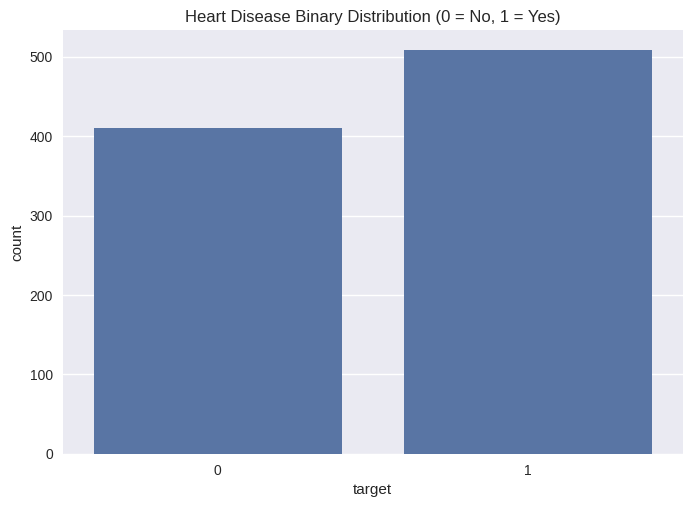

In [10]:
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns=['num'], inplace=True)

print("Binary target distribution (proportion):")
print(df['target'].value_counts(normalize=True))
sns.countplot(x='target', data=df)
plt.title("Heart Disease Binary Distribution (0 = No, 1 = Yes)")
plt.show()


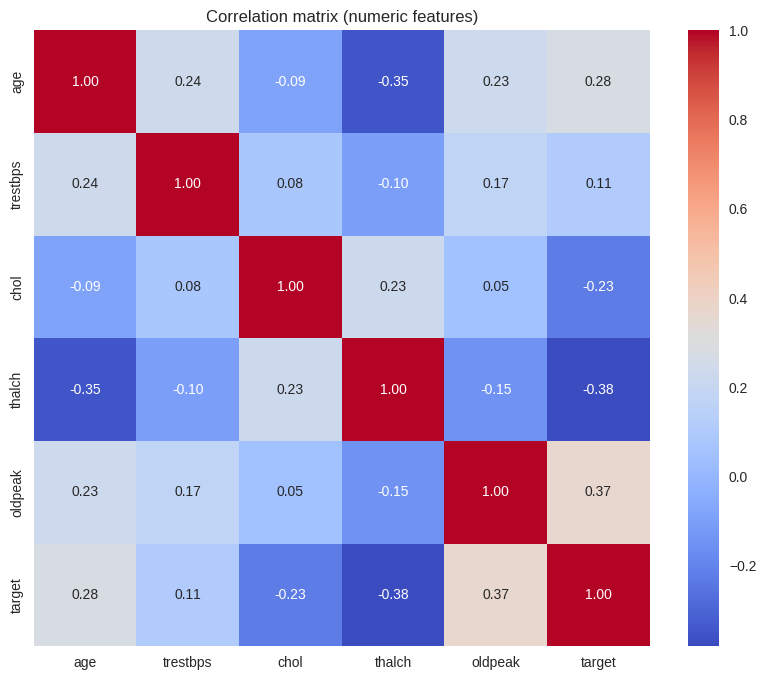

In [11]:
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix (numeric features)")
plt.show()


In [12]:
X = df.drop(columns=['target'])
y = df['target']

categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Build ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='drop')

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical features: ['sex', 'cp', 'restecg']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 734 Test size: 184


In [14]:
pipeline_logreg = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

pipeline_knn = Pipeline([
    ('preproc', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_dt = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42))
])

models = {
    'LogisticRegression': pipeline_logreg,
    'KNN': pipeline_knn,
    'DecisionTree': pipeline_dt
}


In [15]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Logistic Regression

pipeline_logreg.fit(X_train, y_train)
lr_model = pipeline_logreg.named_steps['clf']
feature_names_lr = pipeline_logreg.named_steps['preproc'].get_feature_names_out()

coeffs = lr_model.coef_[0]
feature_importance_lr = pd.DataFrame({'feature': feature_names_lr, 'coefficient': coeffs})
feature_importance_lr = feature_importance_lr.sort_values(by='coefficient', key=abs, ascending=False)
print("Top features - Logistic Regression")
print(feature_importance_lr.head(10))

# K-Nearest Neighbors
pipeline_knn.fit(X_train, y_train)
result_knn = permutation_importance(
    pipeline_knn, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)
feature_names_knn = pipeline_knn.named_steps['preproc'].get_feature_names_out()

# Use the same length as importance array
if len(feature_names_knn) != len(result_knn.importances_mean):
    feature_names_knn = feature_names_knn[:len(result_knn.importances_mean)]

feature_importance_knn = pd.DataFrame({
    'feature': feature_names_knn,
    'importance': result_knn.importances_mean
}).sort_values(by='importance', ascending=False)
print("\nTop features - KNN (via permutation importance)")
print(feature_importance_knn.head(10))

# Decision Tree
pipeline_dt.fit(X_train, y_train)
dt_model = pipeline_dt.named_steps['clf']
feature_names_dt = pipeline_dt.named_steps['preproc'].get_feature_names_out()

feature_importance_dt = pd.DataFrame({
    'feature': feature_names_dt,
    'importance': dt_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nTop features - Decision Tree")
print(feature_importance_dt.head(10))


Top features - Logistic Regression
                   feature  coefficient
7     cat__cp_asymptomatic     1.154209
9   cat__cp_typical angina    -0.870054
4             num__oldpeak     0.615948
6            cat__sex_Male     0.610109
5          cat__sex_Female    -0.606990
3              num__thalch    -0.483959
0                 num__age     0.296397
8      cat__cp_non-anginal    -0.281036
2                num__chol    -0.267444
11     cat__restecg_normal    -0.141715

Top features - KNN (via permutation importance)
                  feature  importance
2               num__chol    0.071739
9  cat__cp_typical angina    0.069022
4            num__oldpeak    0.048913
1           num__trestbps    0.028804
0                num__age    0.014130
5         cat__sex_Female    0.000000
8     cat__cp_non-anginal    0.000000
6           cat__sex_Male   -0.001630
3             num__thalch   -0.002174
7    cat__cp_asymptomatic   -0.011957

Top features - Decision Tree
                          fe

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print(f"{name}  -- Accuracy: {acc_scores.mean():.3f} ± {acc_scores.std():.3f}  |  ROC AUC: {roc_scores.mean():.3f} ± {roc_scores.std():.3f}")


LogisticRegression  -- Accuracy: 0.791 ± 0.012  |  ROC AUC: 0.870 ± 0.014
KNN  -- Accuracy: 0.800 ± 0.023  |  ROC AUC: 0.847 ± 0.023
DecisionTree  -- Accuracy: 0.741 ± 0.006  |  ROC AUC: 0.803 ± 0.011



Training and evaluating: LogisticRegression
              precision    recall  f1-score   support

           0     0.7927    0.7927    0.7927        82
           1     0.8333    0.8333    0.8333       102

    accuracy                         0.8152       184
   macro avg     0.8130    0.8130    0.8130       184
weighted avg     0.8152    0.8152    0.8152       184

ROC AUC (test): 0.9058


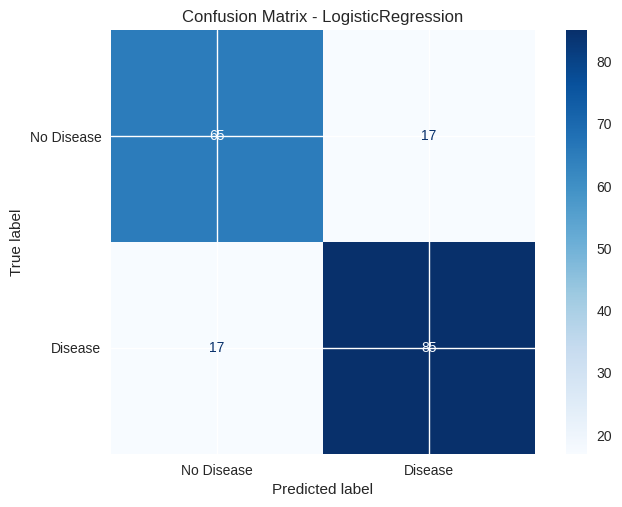


Training and evaluating: KNN
              precision    recall  f1-score   support

           0     0.8158    0.7561    0.7848        82
           1     0.8148    0.8627    0.8381       102

    accuracy                         0.8152       184
   macro avg     0.8153    0.8094    0.8115       184
weighted avg     0.8152    0.8152    0.8143       184

ROC AUC (test): 0.8745


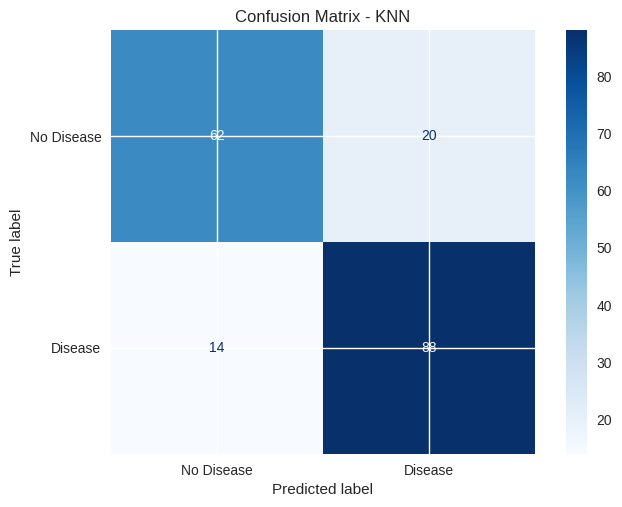


Training and evaluating: DecisionTree
              precision    recall  f1-score   support

           0     0.7303    0.7927    0.7602        82
           1     0.8211    0.7647    0.7919       102

    accuracy                         0.7772       184
   macro avg     0.7757    0.7787    0.7761       184
weighted avg     0.7806    0.7772    0.7778       184

ROC AUC (test): 0.8739


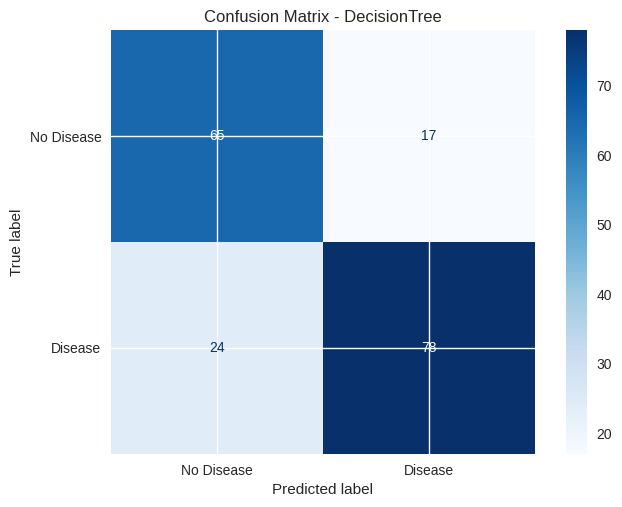

In [17]:
fitted_models = {}
evaluation_results = {}

for name, pipeline in models.items():
    print(f"\nTraining and evaluating: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # For ROC AUC (binary) get probability of class 1 when available
    try:
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None

    print(classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        print("ROC AUC (test):", round(roc_auc_score(y_test, y_proba), 4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


    fitted_models[name] = pipeline
    evaluation_results[name] = {
        'y_pred': y_pred,
        'y_proba': y_proba,
        'confusion_matrix': cm
    }


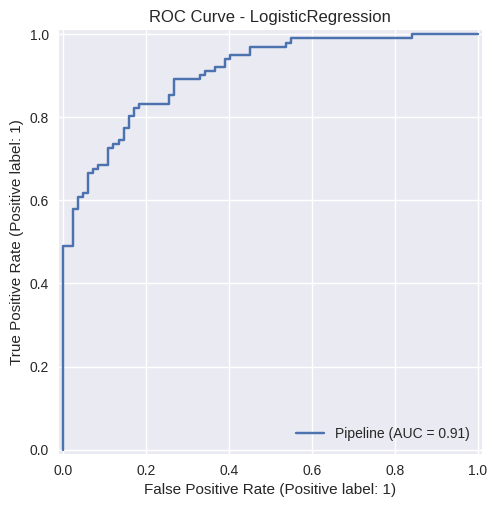

In [18]:
best_name = 'LogisticRegression'
best_pipeline = fitted_models[best_name]
RocCurveDisplay.from_estimator(best_pipeline, X_test, y_test)
plt.title(f"ROC Curve - {best_name}")
plt.show()


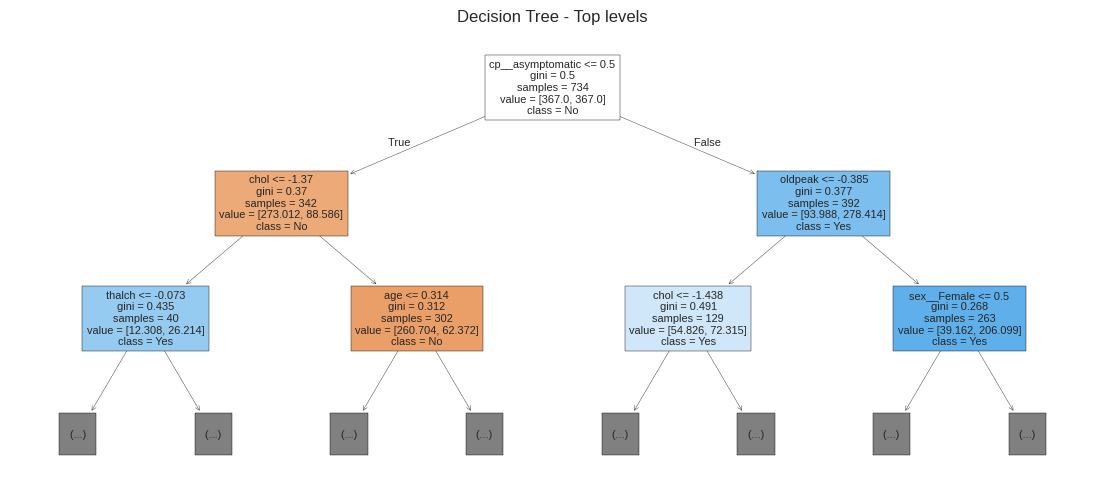

In [19]:
def get_feature_names_from_column_transformer(column_transformer):
    """
    Returns list of feature names after ColumnTransformer transformation.
    Works for OneHotEncoder with sparse=False and StandardScaler.
    """
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps'):
            raise NotImplementedError("Nested pipeline feature names not implemented in helper.")
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            ohe = trans
            categories = ohe.categories_
            for col, cat_vals in zip(cols, categories):
                feature_names.extend([f"{col}__{v}" for v in cat_vals])
        else:
            feature_names.extend(cols)
    return feature_names

# Only plot if the model is a tree and small enough
if isinstance(fitted_models['DecisionTree'].named_steps['clf'], DecisionTreeClassifier):
    # get the tree estimator
    tree_pipeline = fitted_models['DecisionTree']
    tree_clf = tree_pipeline.named_steps['clf']
    feature_names = get_feature_names_from_column_transformer(tree_pipeline.named_steps['preproc'])
    plt.figure(figsize=(14,6))
    plot_tree(tree_clf, feature_names=feature_names, class_names=['No','Yes'], filled=True, max_depth=2)
    plt.title("Decision Tree - Top levels")
    plt.show()


In [20]:
os.makedirs('models', exist_ok=True)
best_pipeline_name = best_name
joblib.dump(fitted_models[best_pipeline_name], f'models/{best_pipeline_name}_pipeline.pkl')
print(f"Saved pipeline to models/{best_pipeline_name}_pipeline.pkl")


Saved pipeline to models/LogisticRegression_pipeline.pkl


In [21]:
!git clone https://github.com/Miideh/Heart-Disease-Prediction-Supervised-Learning-.git

Cloning into 'Heart-Disease-Prediction-Supervised-Learning-'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [24]:
!ls


cleanned.csv
drive
Heart-Disease-Prediction-Supervised-Learning-
heart-disease-uci-dataset.zip
models
sample_data
Supervised_Learning_Predicting_Heart_Disease.ipynb
